In [1]:
from lxml import etree
import pdb
import re
from xml.dom import minidom
import numpy as np
import pdb
from skimage.draw import polygon
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd


In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv2D, Reshape,Conv2DTranspose,Flatten, MaxPooling2D,Dropout,UpSampling2D,concatenate


In [9]:
from skimage import measure
import scipy
from scipy import ndimage

In [214]:
#get train list
train_path='./cubicasa5k/train.txt' 
data_folder='./cubicasa5k'
data_path=['./cubicasa5k'+i for i in np.genfromtxt(train_path,dtype='str')]

In [215]:
test_path='./cubicasa5k/test.txt' 
data_path2 = ['./cubicasa5k'+i for i in np.genfromtxt(test_path,dtype='str')]

In [3]:

class Wall:
    def __init__(self, id, end_points, direction, width, name):
        self.id = id
        self.name = name
        self.end_points = end_points
        self.direction = direction
        self.max_width = width
        self.min_width = width

    def change_end_points(self):
        if self.direction == 'V':
            self.end_points[0][0] = np.mean(np.array(self.min_coord))
            self.end_points[1][0] = self.end_points[0][0]
        elif self.direction == 'H':
            self.end_points[0][1] = np.mean(np.array(self.min_coord))
            self.end_points[1][1] = self.end_points[0][1]

    def get_length(self, end_points):
        return calc_distance(end_points[0], end_points[1])
class PolygonWall(Wall):
    def __init__(self, e, id, shape=None):
        self.id = id
        self.name = e.getAttribute('id')
        self.X, self.Y = self.get_points(e)
        if abs(max(self.X)-min(self.X)) < 4 or abs(max(self.Y)-min(self.Y)) < 4:
            # wall is too small and we ignore it.
            raise ValueError("small wall")
        if shape:
            self.X = np.clip(self.X, 0, shape[1])
            self.Y = np.clip(self.Y, 0, shape[0])
        # self.X, self.Y = self.sort_X_Y(self.X, self.Y)
        self.rr, self.cc = polygon(self.Y, self.X)
        #direction = self.get_direction(self.X, self.Y)
        #end_points = self.get_end_points(self.X, self.Y, direction)
        #self.min_width = self.get_width(self.X, self.Y, direction)
        #self.max_width = self.min_width

        #Wall.__init__(self, id, end_points, direction, self.max_width, self.name)
        #self.length = self.get_length(self.end_points)
        #self.center = self.get_center(self.X, self.Y)
        #self.min_coord, self.max_coord = self.get_width_coods(self.X, self.Y)

    def get_points(self, e):
        pol = next(p for p in e.childNodes if p.nodeName == "polygon")
        points = pol.getAttribute("points").split(' ')
        points = points[:-1]

        X, Y = np.array([]), np.array([])
        for a in points:
            x, y = a.split(',')
            X = np.append(X, np.round(float(x)))
            Y = np.append(Y, np.round(float(y)))

        return X, Y



In [4]:
def clip_outside( rr, cc,shape):
        s = np.column_stack((rr, cc))
        s = s[s[:, 0] < shape[0]]
        s = s[s[:, 1] < shape[1]]

        return s[:, 0], s[:, 1]
def extract_wall(data_path):
    fplan=cv2.imread(data_path+'F1_scaled.png')
    fplan=cv2.cvtColor(fplan,cv2.COLOR_BGR2RGB)
    height,width,nchannel=fplan.shape
    #fplan=np.moveaxis(fplan,-1,0)
    svg=minidom.parse(data_path+'model.svg')
    walls=np.zeros((height,width),dtype=np.uint8)
    wall_id=0
    shape=height,width
    for e in svg.getElementsByTagName('g'):
        try:
            if e.getAttribute("id")=="Wall":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 1
                wall_id+=1
                #plt.imshow(walls)
                #plt.show()
            if e.getAttribute("id")=="Railing":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 0.1
                wall_id+=1
        except ValueError as k:
            if str(k)=='small wall':
                continue
    input_image=cv2.resize(fplan,(256,256))
    wall_target=cv2.resize(walls,(256,256))
    return input_image,wall_target
    
    

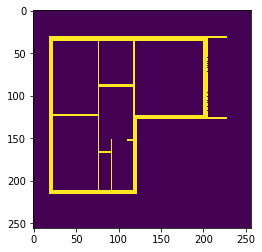

In [79]:
x=extract_wall(test)
plt.imshow(x[1])

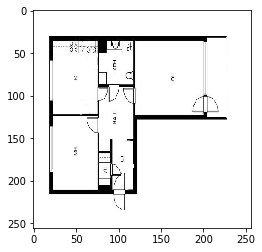

In [71]:
re = cv2.imread(test+'F1_scaled.png')
re = cv2.resize(re,(256,256))
plt.imshow(re)

In [206]:
test=data_path[10]
x=extract_wall(test)

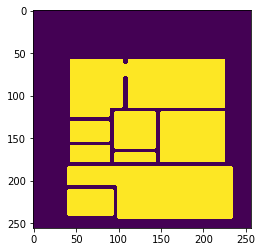

In [207]:
mask = ndimage.binary_dilation(x[1]).astype(np.float32)
mask = np.ones((256,256)) - mask

mask1 = mask.copy()
row = np.any(mask1==0,axis = 1)==1
col = np.any(mask1==0,axis = 0)==1
row1 = np.array([row]*256).transpose().astype(np.int8)
col1 = np.array([col]*256).astype(np.int8)
mask1 = np.floor((row1+col1)/2)

mask2 = np.floor((mask + mask1)/2)
mask2 = ndimage.binary_erosion(mask2).astype(np.float32)
mask2 = ndimage.binary_dilation(mask2).astype(np.float32)

mask2_3d = np.array([mask2]*3)
mask2_3d = mask2_3d.transpose((1, 2, 0))
plt.imshow(mask2)

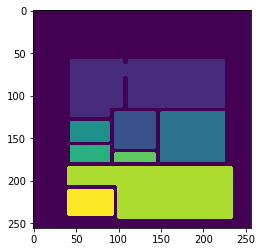

In [212]:
labels = measure.label(mask2)
plt.imshow(labels)

### code to create masks, saved as np.array

In [5]:
train_path='./cubicasa5k/train.txt' 
data_path1=['./cubicasa5k'+i for i in np.genfromtxt(train_path,dtype='str')]

test_path='./cubicasa5k/test.txt' 
data_path2 = ['./cubicasa5k'+i for i in np.genfromtxt(test_path,dtype='str')]

In [10]:
data_path = data_path1
Y=np.empty((len(data_path),256,256))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    x=extract_wall(data_path[i])
    
    mask = ndimage.binary_dilation(x[1]).astype(np.float32)
    mask = np.ones((256,256)) - mask

    mask1 = mask.copy()
    row = np.any(mask1==0,axis = 1)==1
    col = np.any(mask1==0,axis = 0)==1
    row1 = np.array([row]*256).transpose().astype(np.int8)
    col1 = np.array([col]*256).astype(np.int8)
    mask1 = np.floor((row1+col1)/2)

    mask2 = np.floor((mask + mask1)/2)
    mask2 = ndimage.binary_erosion(mask2).astype(np.float32)
    mask2 = ndimage.binary_dilation(mask2).astype(np.float32)
    labels = measure.label(mask2)

    Y[i] = labels

    
outfile = './saved_arrays/train_label.npy'

np.save(outfile, Y)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


In [11]:
data_path = data_path2
Y=np.empty((len(data_path),256,256))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    x=extract_wall(data_path[i])
    
    mask = ndimage.binary_dilation(x[1]).astype(np.float32)
    mask = np.ones((256,256)) - mask

    mask1 = mask.copy()
    row = np.any(mask1==0,axis = 1)==1
    col = np.any(mask1==0,axis = 0)==1
    row1 = np.array([row]*256).transpose().astype(np.int8)
    col1 = np.array([col]*256).astype(np.int8)
    mask1 = np.floor((row1+col1)/2)

    mask2 = np.floor((mask + mask1)/2)
    mask2 = ndimage.binary_erosion(mask2).astype(np.float32)
    mask2 = ndimage.binary_dilation(mask2).astype(np.float32)
    labels = measure.label(mask2)

    Y[i] = labels

    
outfile = './saved_arrays/test_label.npy'

np.save(outfile, Y)


0
100
200
300


In [ ]:

train_path='./cubicasa5k/train_h.txt' 
data_path1=['./cubicasa5k'+i for i in np.genfromtxt(train_path,dtype='str')]


data_path = data_path1
Y=np.empty((len(data_path),256,256))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    x=extract_wall(data_path[i])
    
    mask = ndimage.binary_dilation(x[1]).astype(np.float32)
    mask = np.ones((256,256)) - mask

    mask1 = mask.copy()
    row = np.any(mask1==0,axis = 1)==1
    col = np.any(mask1==0,axis = 0)==1
    row1 = np.array([row]*256).transpose().astype(np.int8)
    col1 = np.array([col]*256).astype(np.int8)
    mask1 = np.floor((row1+col1)/2)

    mask2 = np.floor((mask + mask1)/2)
    mask2 = ndimage.binary_erosion(mask2).astype(np.float32)
    mask2 = ndimage.binary_dilation(mask2).astype(np.float32)
    labels = measure.label(mask2)

    Y[i] = labels

outfile = './saved_arrays/train_label_h.npy'

np.save(outfile, Y)   

In [23]:
test_path='./cubicasa5k/val_h.txt' 
data_path2 = ['./cubicasa5k'+i for i in np.genfromtxt(test_path,dtype='str')]



data_path = data_path2
Y=np.empty((len(data_path),256,256))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    x=extract_wall(data_path[i])
    
    mask = ndimage.binary_dilation(x[1]).astype(np.float32)
    mask = np.ones((256,256)) - mask

    mask1 = mask.copy()
    row = np.any(mask1==0,axis = 1)==1
    col = np.any(mask1==0,axis = 0)==1
    row1 = np.array([row]*256).transpose().astype(np.int8)
    col1 = np.array([col]*256).astype(np.int8)
    mask1 = np.floor((row1+col1)/2)

    mask2 = np.floor((mask + mask1)/2)
    mask2 = ndimage.binary_erosion(mask2).astype(np.float32)
    mask2 = ndimage.binary_dilation(mask2).astype(np.float32)
    labels = measure.label(mask2)

    Y[i] = labels

    
outfile = './saved_arrays/test_label_h.npy'

np.save(outfile, Y)


0
100


In [24]:
#Y1 = np.load(outfile)
#len(Y1)
#plt.imshow(Y1[1])

### weighted loss, to be added

In [97]:
from tensorflow.keras.utils import to_categorical
from scipy import stats

rand_out = np.random.randint(0,4,size = (256,256))
test = to_categorical(rand_out)
mask = Y[34]

In [83]:
#test = final output layer
#mask = input mask
#alpha = weight of added loss

### this is discarded as gradient can't be estimated

back = np.argmax(test,axis = 2)+1
n_room = int(mask.max())
weigheted_loss = 0
for i_room in range(n_room+1):
    mask_temp = (mask == i_room)


    eval = back*mask_temp
    eval.reshape(1,256**2)
    eval = eval[eval>0]
    weigheted_loss_room = 1 - int(stats.mode(eval)[1])/len(eval)
    weigheted_loss += weigheted_loss_room
    
model.add_loss(alpha * weigheted_loss) 


#### NEW PART 

In [124]:
#test = final output layer
#mask = input mask
#alpha = weight of added loss

back = np.argmax(test,axis = 2)
back_down = np.roll(back,1,axis = 0)
back_down[0,:] = 0
back_right = np.roll(back,1)
back_right[:,0] = 0
num_class = back.max()+1

out_mask = tf.constant(to_categorical(back * (mask>0),num_classes = num_class))
out_down_mask = tf.constant(to_categorical(back_down * (mask>0),num_classes = num_class))
out_right_mask = tf.constant(to_categorical(back_right * (mask>0),num_classes = num_class))


model.add_loss(alpha * tf.keras.backend.categorical_crossentropy(out_mask,out_down_mask),alpha * tf.keras.backend.categorical_crossentropy(out_mask,out_right_mask))






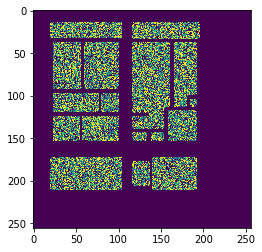

In [119]:
plt.imshow(back * (mask>0))